Fluid Dynamics
==============

*Important:* Please read the [installation page](http://gpeyre.github.io/numerical-tours/installation_python/) for details about how to install the toolboxes.
$\newcommand{\dotp}[2]{\langle #1, #2 \rangle}$
$\newcommand{\enscond}[2]{\lbrace #1, #2 \rbrace}$
$\newcommand{\pd}[2]{ \frac{ \partial #1}{\partial #2} }$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\umax}[1]{\underset{#1}{\max}\;}$
$\newcommand{\umin}[1]{\underset{#1}{\min}\;}$
$\newcommand{\uargmin}[1]{\underset{#1}{argmin}\;}$
$\newcommand{\norm}[1]{\|#1\|}$
$\newcommand{\abs}[1]{\left|#1\right|}$
$\newcommand{\choice}[1]{ \left\{  \begin{array}{l} #1 \end{array} \right. }$
$\newcommand{\pa}[1]{\left(#1\right)}$
$\newcommand{\diag}[1]{{diag}\left( #1 \right)}$
$\newcommand{\qandq}{\quad\text{and}\quad}$
$\newcommand{\qwhereq}{\quad\text{where}\quad}$
$\newcommand{\qifq}{ \quad \text{if} \quad }$
$\newcommand{\qarrq}{ \quad \Longrightarrow \quad }$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\CC}{\mathbb{C}}$
$\newcommand{\RR}{\mathbb{R}}$
$\newcommand{\EE}{\mathbb{E}}$
$\newcommand{\Zz}{\mathcal{Z}}$
$\newcommand{\Ww}{\mathcal{W}}$
$\newcommand{\Vv}{\mathcal{V}}$
$\newcommand{\Nn}{\mathcal{N}}$
$\newcommand{\NN}{\mathcal{N}}$
$\newcommand{\Hh}{\mathcal{H}}$
$\newcommand{\Bb}{\mathcal{B}}$
$\newcommand{\Ee}{\mathcal{E}}$
$\newcommand{\Cc}{\mathcal{C}}$
$\newcommand{\Gg}{\mathcal{G}}$
$\newcommand{\Ss}{\mathcal{S}}$
$\newcommand{\Pp}{\mathcal{P}}$
$\newcommand{\Ff}{\mathcal{F}}$
$\newcommand{\Xx}{\mathcal{X}}$
$\newcommand{\Mm}{\mathcal{M}}$
$\newcommand{\Ii}{\mathcal{I}}$
$\newcommand{\Dd}{\mathcal{D}}$
$\newcommand{\Ll}{\mathcal{L}}$
$\newcommand{\Tt}{\mathcal{T}}$
$\newcommand{\si}{\sigma}$
$\newcommand{\al}{\alpha}$
$\newcommand{\la}{\lambda}$
$\newcommand{\ga}{\gamma}$
$\newcommand{\Ga}{\Gamma}$
$\newcommand{\La}{\Lambda}$
$\newcommand{\si}{\sigma}$
$\newcommand{\Si}{\Sigma}$
$\newcommand{\be}{\beta}$
$\newcommand{\de}{\delta}$
$\newcommand{\De}{\Delta}$
$\newcommand{\phi}{\varphi}$
$\newcommand{\th}{\theta}$
$\newcommand{\om}{\omega}$
$\newcommand{\Om}{\Omega}$

This numerical tour explores fluid dynamics for image generation.

In [1]:
from __future__ import division

import numpy as np
import scipy as scp
import pylab as pyl
import matplotlib.pyplot as plt

from nt_toolbox.general import *
from nt_toolbox.signal import *

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%load_ext autoreload
%autoreload 2

Velocity Flow Field
-------------------
A velocity flow is simply a 2-D vector field $V = (V_i)_{i=1}^N \in \RR^{n \times n \times 2}$
where $V_i \in \RR^2$ is one of the $N=n \times n$ vectors at a position indexed by $i$.


It can be generated as a realization of Gaussian process.
The blurring creates correlations in the flow.

In [2]:
n = 128 # grid size

In [3]:
t = np.linspace(0,1,n)
[Y,X] = np.meshgrid(t,t)
gamma = .05 # blurring size
xi1 = np.exp(-(X-Y)**2/gamma)
xi = lambda x: np.dot(np.dot(xi1,x),xi1)

In [4]:
from numpy import random
n = 128
V = np.random.randn(n, n, 2)
for k in range(2):
    V[:,:,k] = xi(V[:,:,k])

Subsampling display operator.

In [5]:
from nt_toolbox.plot_vf import * 
myplot = lambda V: plot_vf(V[np.ix_(np.arange(0,n,6),np.arange(0,n,6),np.arange(2))])

We can display the vector field using arrow.

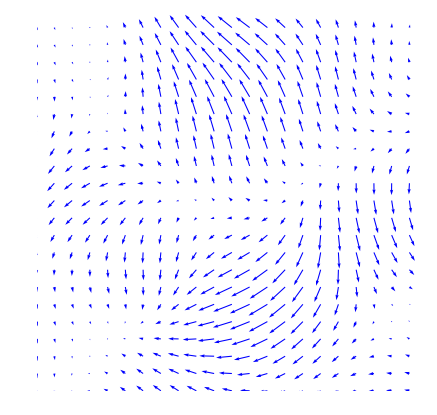

In [6]:
plt.figure(figsize = (7,7))
myplot(V)

We can renormalize the flow, which enhances the singularities. It defines
$\tilde V$ as $\tilde V_i = V_i/\norm{V_i}$.

In [7]:
normalize = lambda V: V/(np.repeat(np.maximum(1e-9*np.ones(np.shape(V)[:2]), np.sqrt(np.sum(V**2, 2)))[:,:,np.newaxis],2,axis=2))

Display.

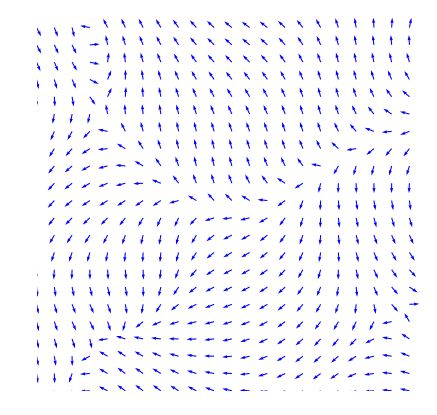

In [8]:
plt.figure(figsize = (7,7))
myplot(normalize(V))

Incompressible Flows
--------------------
An incompressible flow has a vanishing divergence. The set of vector
incompressible flow defines a sub-space of $\RR^{n \times n \times 2}$
$$ \Ii = \enscond{V}{ \text{div}(V)=0 }
  \qwhereq \text{div}(V) = \pd{V}{x_1} + \pd{V}{x_2} \in \RR^{n \times n}. $$
Here $\pd{}{x_s}$ for $s=1,2$ are finite differences approximation of
the horizontal and vertical derivative operators (we suppose here periodic boundary conditions).



The orthogonal projection $U = \text{Proj}_{\Ii}(V)$ on  $\Ii$ is
computed by solving a Poisson equation
$$ U = V-\nabla A \qwhereq \Delta A = \text{div}(V). $$


This is especially simple for periodic boundary conditions since $A$ can
be computed over the Fourier domain as
$$ \forall \om \neq 0, \quad \hat A(\om) = \frac{\hat Y(\om)}{\mu(\om)}
  \qwhereq Y = \text{div}(V) \qandq
  \mu(\om_1,\om_2) = -4 \sin(\om_1 \pi / n)^2 -4 \sin(\om_2 \pi / n)^2  $$
and $\hat A(0)=0$.



Compute the kernel $\mu(\om)$.

In [9]:
Y, X = np.meshgrid(np.arange(0,n),np.arange(0,n))
mu = np.sin(X*np.pi/n)**2
mu = -4*(mu + np.transpose(mu))
mu[0,0] = 1

In [10]:
a = np.hstack((np.arange(1,n),[0]))
b = np.hstack(([n-1],np.arange(n-1)))
Grad = lambda f: np.dstack( (f[a,:]-f, f[:,a]-f) )
Div = lambda v: v[b,:,0]-v[:,:,0] + v[:,b,1]-v[:,:,1]
Delta = lambda g: (g[a,:] + g[b,:] + g[:,a] + g[:,b]) - 4*g
DeltaV = lambda V: np.dstack( (Delta(V[:,:,0]), Delta(V[:,:,1]))  )

Computation of $A$.

In [11]:
#from nt_toolbox.div import *
#A = lambda V: np.real(pyl.ifft2(pyl.fft2(Div(V[:,:,0], V[:,:,1], bound="per"))/mu))
A = lambda V: np.real(pyl.ifft2(pyl.fft2(Div(V))/mu))

Projection on incompressible flows.

In [12]:
ProjI = lambda V: V + Grad(A(V))

Display $U=\text{Proj}_{\Ii}(V)$.

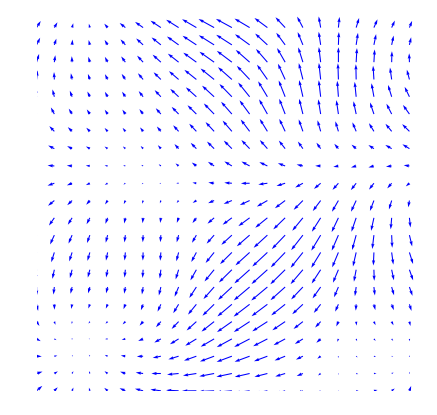

In [13]:
U = ProjI(V)
plt.figure(figsize=(7,7))
myplot(U)

Display $W=U-V$ the irrotational component of $V$.

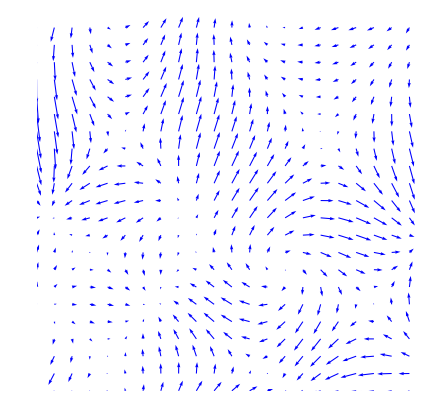

In [14]:
plt.figure(figsize=(7,7))
myplot(V-U)

Note that the decomposition $V=U+W$ is called the Hoge decomposition of
the vector field.


Image Advection Along the Flow
------------------------------
A flow defines a warping operator that transport the content of an image
along the streaming of the flow.


We load an image $f$.

In [15]:
f = load_image("nt_toolbox/data/hibiscus.bmp", 2*n)
f = f[np.ix_(np.arange(n-n//2,n+n//2),np.arange(n-n//2,n+n//2))]

Given some vector field $U$, the warping operator $f_1 = \Ww_U(f)$
along the flow is defined
$$ f_1(x) = f(x+U(x)) $$
i.e. it advects the values of $f$ by the vector field $U$ to obtain the values of $f_1$.


We define $U$ as a scaled normalized incompressible flow.

In [16]:
U = normalize( ProjI(V) )

Helper function: enforce periodicity.

In [17]:
periodic = lambda P: np.concatenate(((P[:,:,0]%n)[:,:,np.newaxis], (P[:,:,1]%n)[:,:,np.newaxis]), axis=2)

Helper function: extend an image by 1 pixel to avoid boundary problems.

In [18]:
extend1 = lambda f: np.hstack((f,f[:,[0]]))
extend = lambda f: np.transpose(extend1(np.transpose(extend1(f))))

Helper function: bilinear interpolation on a grid.

In [19]:
from scipy import interpolate

def myinterp(P1,f1,Pi):
    return interpolate.griddata(P1, np.ravel(f1),(Pi[:,:,1],Pi[:,:,0]))

First we compute the initial and wraped grids.

In [20]:
Y, X = np.meshgrid(np.arange(0,n),np.arange(0,n))
P = np.concatenate((X[:,:,np.newaxis],Y[:,:,np.newaxis]),axis=2)
Y1, X1 = np.meshgrid(np.arange(0,n+1),np.arange(0,n+1))
P1 = np.concatenate((np.ravel(Y1)[:,np.newaxis],np.ravel(X1)[:,np.newaxis]),axis=1)

Defines the warping operator $\Ww_U$.

In [21]:
W = lambda f, U: myinterp(P1, extend(f), periodic(P - U))

Display a warped image $\Ww_{\rho U}(f)$ for some scaling $\rho$.

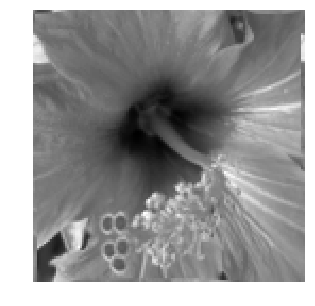

In [22]:
rho = 2
plt.figure(figsize = (5,5))
imageplot(W(f, rho*U))

__Exercise 1__

Display $\Ww_{\rho U}(f)$ for various values of $\rho$.

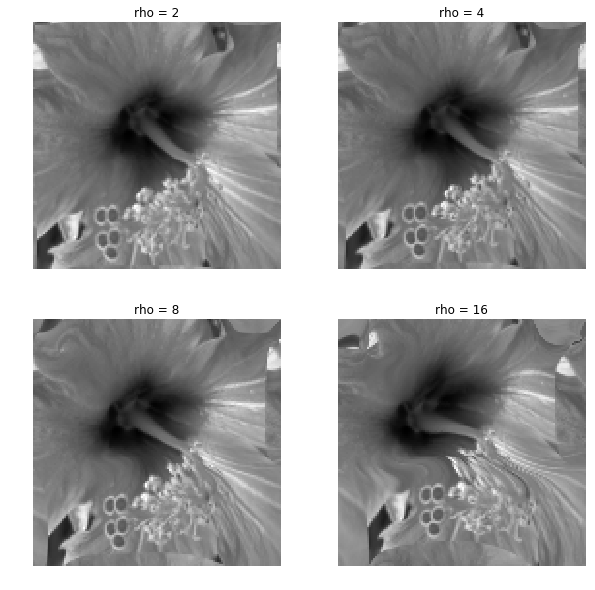

In [23]:
run -i nt_solutions/graphics_5_fluids/exo1

In [24]:
## Insert your code here.

__Exercise 2__

Define an iterative scheme via:
$$ f^{(\ell+1)} = \Ww_{\rho U}(f^{(\ell)}).  $$
Display the result $f^{(\ell)}$, which corresponds approximately to solving
an advection equation at time $t=\ell \rho$.

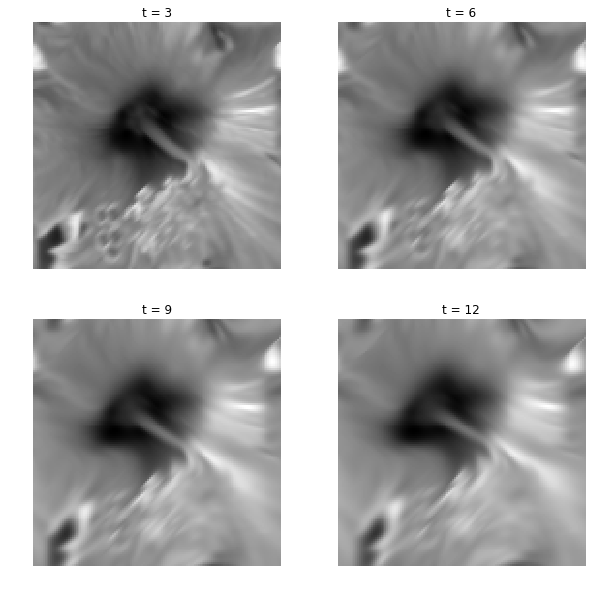

In [25]:
run -i nt_solutions/graphics_5_fluids/exo2

In [26]:
## Insert your code here.

Fluid Dynamics
--------------
Fluid dynamics solves the incompressible Navier-Stokes equations to
evolve in time the vector field.


We discribe here a simple algorithm introduced in:


J. Stam, _Stable Fluids,_
SIGGRAPH'99, 1999, p. 121-128.


It proposes a semi-implicit scheme for the resolution of the Navier
Stockes equations for the movement of incompressible fluids
$$
      \pd{V}{t} =
      \text{Proj}_{\Ii}\pa{
          -(V \cdot \nabla) V + \nu \Delta V + W
      }.
$$
Here $\nu \geq 0$ is the viscosity of the fluid,
$W$ is a source term, $\Delta$ is the Laplacian, and
$-(V \cdot \nabla) V$ is the
non-linear self-advection, where we have used the short-hand
notation $V \cdot \nabla$ for the derivative operator along a flow $V$:
$$ (V \cdot \nabla)U = ( V_1 \pd{U_1}{x_1} + V_2 \pd{U_1}{x_2},
      V_1 \pd{U_2}{x_1} + V_2 \pd{U_2}{x_2} ).$$


In order to visualize the flow, we also advect and diffuse along the flow
a density $g$ of particules, which is a scalar field. Once $V$ has
been computed, it follows a linear PDE
$$
      \pd{g}{t} =
          -(V \cdot \nabla) g + \mu \Delta g + h
$$
with some initial condition at time $t=0$, where $h$ is a source for the density.


In practice, we solve this PDE in parallel to the PDE for $V$.


In the following, we use $W=0$ and $h=0$ (no sources).


Set the viscosity $\nu$ for the velocity field.

In [27]:
nu = 1/10
mu = nu

Extend the warping operator $\Ww_U$ to work with vector fields as input.
This will apply $\Ww_U$ on each channel of the vector field (X and Y coordinates).

In [28]:
#Wt = lambda V, U: np.concatenate((W(V[:,:,0],U)[:,:,np.newaxis],W(V[:,:,1],U)[:,:,np.newaxis]),axis=2)
Wt = lambda V, U: np.dstack( (W(V[:,:,0],U),W(V[:,:,1],U)) )

We discretize the PDE's using some time step $\tau$.

In [29]:
tau = .03

The algorithm computes $V^{(\ell)}$ at iteration $\ell$
which is an approximation of the PDE solution at time $\ell \tau$.
It is computed itertatively as
$$
      \tilde V^{(\ell)} = \Ww_{\tau V^{(\ell)}}( V^{(\ell)} )
  \qandq
      V^{(\ell+1)} = \text{Proj}_{\Ii}\pa{ \tilde V^{(\ell)} + \tau\nu\Delta \tilde V^{(\ell)} + \tau W  }
$$


It computes in parallel the evolution of the density as
$$
      \tilde g^{(\ell)} = \Ww_{\tau V^{(\ell)}}( g^{(\ell)} )
  \qandq
      g^{(\ell+1)} = \tilde g^{(\ell)} + \tau\nu\Delta \tilde g^{(\ell)} + \tau h
$$



Set the initial field $V=V^{(0)}$ at time $t=0$.

In [30]:
U = ProjI(V)

Set the initial density $g=g^{(0)}$ at time $t=0$.

In [31]:
g = np.copy(f)

The first step is to advect the vector field $V$ and $g$ along the flow $V$ itself.
This corresponds to an implict discretization of the term
$-(V \cdot \nabla) V$.

In [32]:
g = W (g, tau*U)
U = Wt(U, tau*U)

We implement the Laplacian using finite difference.

The second step is to diffuse the vector field and the density.

In [33]:
U = U + tau*nu*DeltaV(U)
g = g + tau*mu*Delta(g)

The last step is to ensure incompressibility of $V$ by projecting on $\Ii$.

In [34]:
U = ProjI(U)

__Exercise 3__

Compute the fluid dynamic by iterating these steps.

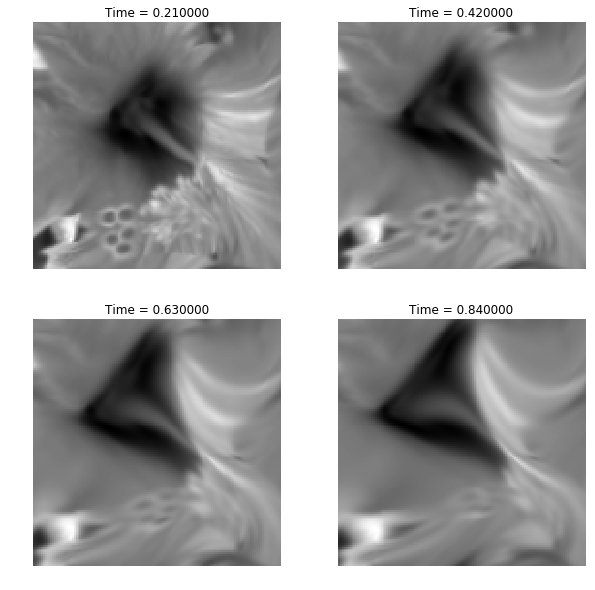

In [35]:
run -i nt_solutions/graphics_5_fluids/exo3

In [36]:
## Insert your code here.